<a href="https://colab.research.google.com/github/JessicaYue256/E-transactions-project-2024/blob/main/2pages_version_UChi_programming_supplement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import libraries**

In [1]:
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

**Import data(csv)**

*dataset: https://drive.google.com/file/d/1dhiAxtRjZiH17sE8H-yy1Z0BZIhW6ynE/view?usp=drive_link*

In [2]:
# This is a dataset about fraudulent e-commerce transactions from kaggle.
# Downloading the dataset from Google Drive using gdown
from google.colab import drive
drive.mount('/content/drive')

file_id = '1dhiAxtRjZiH17sE8H-yy1Z0BZIhW6ynE'
output_path = './file.csv'

url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(url, output_path, quiet=False)

Mounted at /content/drive


Downloading...
From (original): https://drive.google.com/uc?id=1dhiAxtRjZiH17sE8H-yy1Z0BZIhW6ynE
From (redirected): https://drive.google.com/uc?id=1dhiAxtRjZiH17sE8H-yy1Z0BZIhW6ynE&confirm=t&uuid=455e8d42-3844-4e41-b698-f01472a4c428
To: /content/file.csv
100%|██████████| 393M/393M [00:10<00:00, 38.4MB/s]


'./file.csv'

In [3]:
# Reading the CSV file into a DataFrame
df = pd.read_csv('./file.csv')

**Manage different data types & Wrangle data**

In [4]:
# Converting the "Transaction Date" column from object dtype to datetime format
df["Transaction Date"] = pd.to_datetime(df["Transaction Date"])
# Creat new colume: extracting day, day of week, and month from the Transaction Date
df['Transaction Day'] = df["Transaction Date"].dt.day
df["Transaction DOW"] = df["Transaction Date"].dt.day_of_week
df["Transaction Month"] = df["Transaction Date"].dt.month
# Handling Customer Age Data: Replacing values between -9 and 8 with the mean, and values less than -9 with their absolute values.
mean_value = np.round(df['Customer Age'].mean(),0)
df['Customer Age'] = np.where(df['Customer Age'] <= -9, np.abs(df['Customer Age']), df['Customer Age'])
df['Customer Age'] = np.where(df['Customer Age'] < 9, mean_value, df['Customer Age'])
# Creating a new column 'Is Address Match' based on whether Shipping Address and Billing Address are the same
df["Is Address Match"] = (df["Shipping Address"] == df["Billing Address"]).astype(int)
# Creating new binary columns 'Transaction_isweekend' and 'Is_Night_Transaction'
df["Transaction_isweekend"] = df["Transaction DOW"].apply(lambda x: 1 if x >= 5 else 0)
df['Is_Night_Transaction'] = df['Transaction Hour'].apply(lambda x: 1 if 0 <= x < 6 else 0)
# Removing irrelevant features and downcasting datatypes to reduce dataset size
df.drop(columns=["Transaction ID", "Customer ID", "Customer Location", "IP Address",
                 "Transaction Date", "Shipping Address", "Billing Address", "Transaction DOW"], inplace=True)
# Downcasting int and float columns to optimize memory usage
int_col = df.select_dtypes(include="int").columns
float_col = df.select_dtypes(include="float").columns
df[int_col] = df[int_col].apply(pd.to_numeric, downcast='integer')
df[float_col] = df[float_col].apply(pd.to_numeric, downcast='float')
# Renaming columns by replacing spaces with underscores
df.columns = df.columns.str.replace(' ', '_')

**Write function & Use functions for data analysis**

In [12]:
# Drop the unnecessary column
df1 = df.drop(columns=["Device_Used","Payment_Method","Product_Category"])
# Handle the data imbalance using downsampling
df_majority = df1[df1.Is_Fraudulent == 0]  # Majority class (non-fraudulent)
df_minority = df1[df1.Is_Fraudulent == 1]  # Minority class (fraudulent)
# Downsample the majority class to match the minority class size
df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=42)
df_balanced = pd.concat([df_majority_downsampled, df_minority])
# Shuffle the resulting DataFrame
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

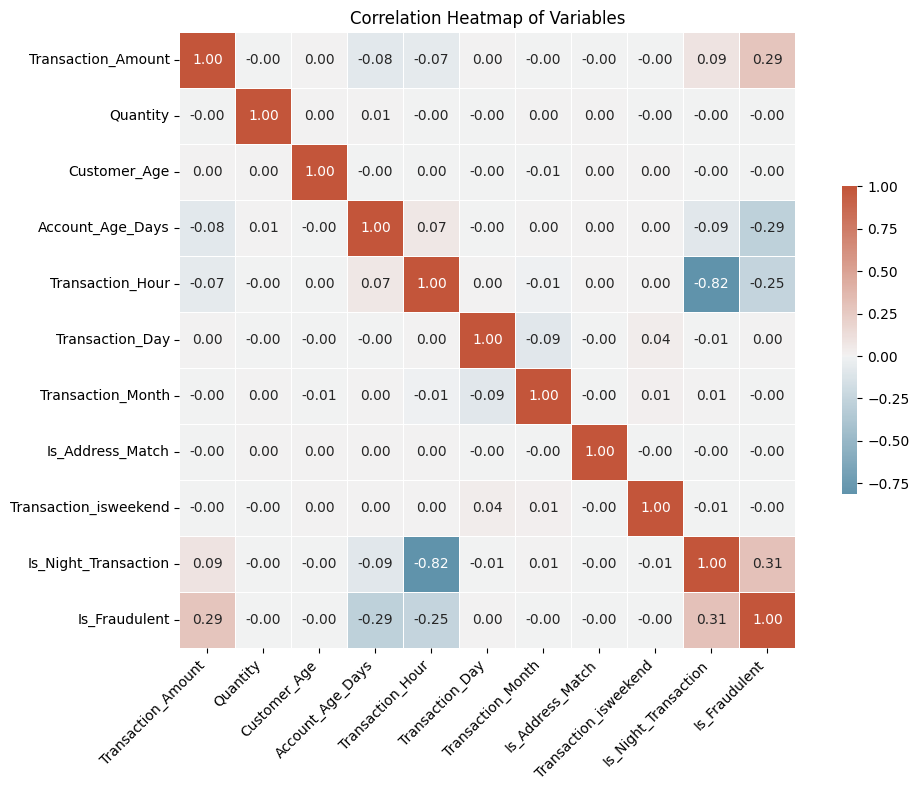

In [6]:
# Split the balanced dataset into features (X) and target (y)
X = df_balanced.drop('Is_Fraudulent', axis=1)
y = df_balanced['Is_Fraudulent']
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Create the train DataFrame and add the target column for easy visualization
df_train = X_train.copy()
df_train['Is_Fraudulent'] = y_train
# Create the test DataFrame
df_test = X_test.copy()
df_test['Is_Fraudulent'] = y_test
# Generate the correlation matrix for the training data
corr = df_train.corr()
# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
heatmap = sns.heatmap(corr, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5,
                      cbar_kws={"shrink": .5}, annot=True, fmt=".2f")
# Rotate the x and y axis labels for better readability
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Correlation Heatmap of Variables')
plt.show()

In [9]:
# Function to fit a logistic regression model and display summary
def fit_logistic_regression(formula, data):
    model = smf.logit(formula, data=data)
    result = model.fit()
    print(result.summary())
    return result

In [10]:
# Train the regression model and improve based on P value
formula2 = "Is_Fraudulent ~ Transaction_Amount + Account_Age_Days + Is_Night_Transaction"
result2 = fit_logistic_regression(formula2, df_train)

Optimization terminated successfully.
         Current function value: 0.553805
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          Is_Fraudulent   No. Observations:               118140
Model:                          Logit   Df Residuals:                   118136
Method:                           MLE   Df Model:                            3
Date:                Sat, 18 Jan 2025   Pseudo R-squ.:                  0.2010
Time:                        14:11:57   Log-Likelihood:                -65426.
converged:                       True   LL-Null:                       -81888.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.3771      0.013    -27.939      0.000      -0.404      -0.351

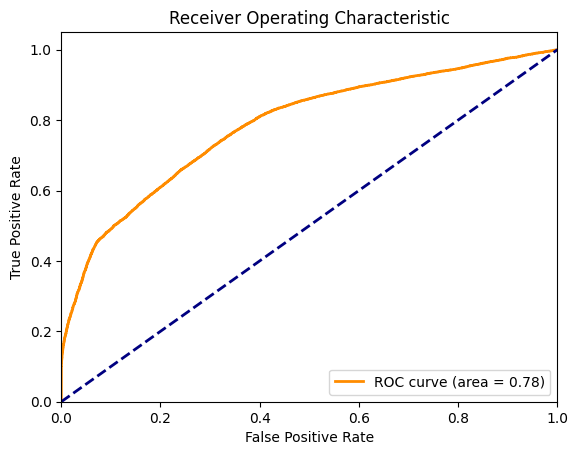

AUC: 0.7848
Confusion Matrix:
 [[11222  3566]
 [ 5033  9715]]

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.76      0.72     14788
           1       0.73      0.66      0.69     14748

    accuracy                           0.71     29536
   macro avg       0.71      0.71      0.71     29536
weighted avg       0.71      0.71      0.71     29536



In [11]:
# Function to evaluate model performance
def evaluate_model(model, df_test):
    prob_fraud = model.predict(sm.add_constant(df_test))
    pred_fraud = (prob_fraud > 0.5).astype(int)
    # Confusion Matrix and Classification Report
    cm = confusion_matrix(df_test['Is_Fraudulent'], pred_fraud)
    cr = classification_report(df_test['Is_Fraudulent'], pred_fraud)
    # ROC Curve
    fpr, tpr, _ = roc_curve(df_test['Is_Fraudulent'], prob_fraud)
    roc_auc = auc(fpr, tpr)
    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    # Calculate and print AUC score
    auc_score = roc_auc_score(df_test['Is_Fraudulent'], prob_fraud)
    print(f'AUC: {auc_score:.4f}')
    # Print metrics
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:\n", cr)

# Evaluate the second model (from formula2)
evaluate_model(result2, df_test)